# `DecisionTreeClassifier` - HyperparameterTuning

In [42]:
from sklearn.tree import DecisionTreeClassifier
from src.preprocessing import Passthrough
from sklearn.pipeline import Pipeline, make_pipeline
from src.utils import print_params
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

## Load the data

In [10]:
import pandas as pd
import numpy as np
from src.utils import load_data
df = load_data()
dfX, dfy = load_data(return_X_y=True)

## Import the `DataPipeline`

In [11]:
from src.pipeline import dp1 as dp

In [12]:
dp.get_description(markdown=True)


1. Drop Name, Ticket - requires Feature Engineering
2. Embarked: most_frequent imputation using SimpleImputer
2. OneHotEncoder for Sex, Embarked
3. Drop Cabin - requires Feature Engineering/(?And Not Imputation)
4. Age : Applied Mean Imputation
5. Fare : Applied Mean Imputation
6. Applied StandardScaler at the end to all features

MLmodel: SVC

In [13]:
dp.set_data(df)
dfX_pre, dfy_pre = dp.prepare()

In [14]:
dp.mlmodel = DecisionTreeClassifier()

## `prepare` and `preprocess`

In [15]:
dp.set_data(df)
dfX_pre, dfy_pre = dp.prepare()
dp.preprocess()

array([[ 0.73534203, -0.30794088,  0.61679395, ...,  0.82520863,
         0.43135024, -0.47432585],
       [-1.35991138, -0.30794088, -1.62128697, ..., -1.57221121,
         0.43135024, -0.47432585],
       [-1.35991138, -0.30794088,  0.61679395, ...,  0.82520863,
        -0.47519908, -0.47432585],
       ...,
       [-1.35991138, -0.30794088,  0.61679395, ...,  0.82520863,
         0.43135024,  2.00611934],
       [ 0.73534203, -0.30794088, -1.62128697, ..., -1.57221121,
        -0.47519908, -0.47432585],
       [ 0.73534203,  3.24737656, -1.62128697, ...,  0.82520863,
        -0.47519908, -0.47432585]])

## Fit the `DecisionTreeClassifier` and get the `tree`

In [16]:
dp.fit()
tree = dp.mlmodel.tree_

## Let' see the `max_depth` reached when it's set to None

In [17]:
max_depth_train = tree.max_depth
max_depth_train

20

In [18]:
dp.score()

1.0

#### Function to reasonable values for `max_depth`

In [19]:
def get_max_depth_vals(max_depth, nvals=5):
    vals = list(np.ceil((2**np.linspace(np.log2(4), np.log2(max_depth*0.8), nvals))))
    vals.append(None)
    return vals

max_depth = get_max_depth_vals(max_depth_train)
max_depth

[4.0, 6.0, 8.0, 12.0, 16.0, None]

In [20]:
import matplotlib.pyplot as plt

In [21]:
from io import StringIO
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz

#### Maybe make this into a draw_decision_tree function?

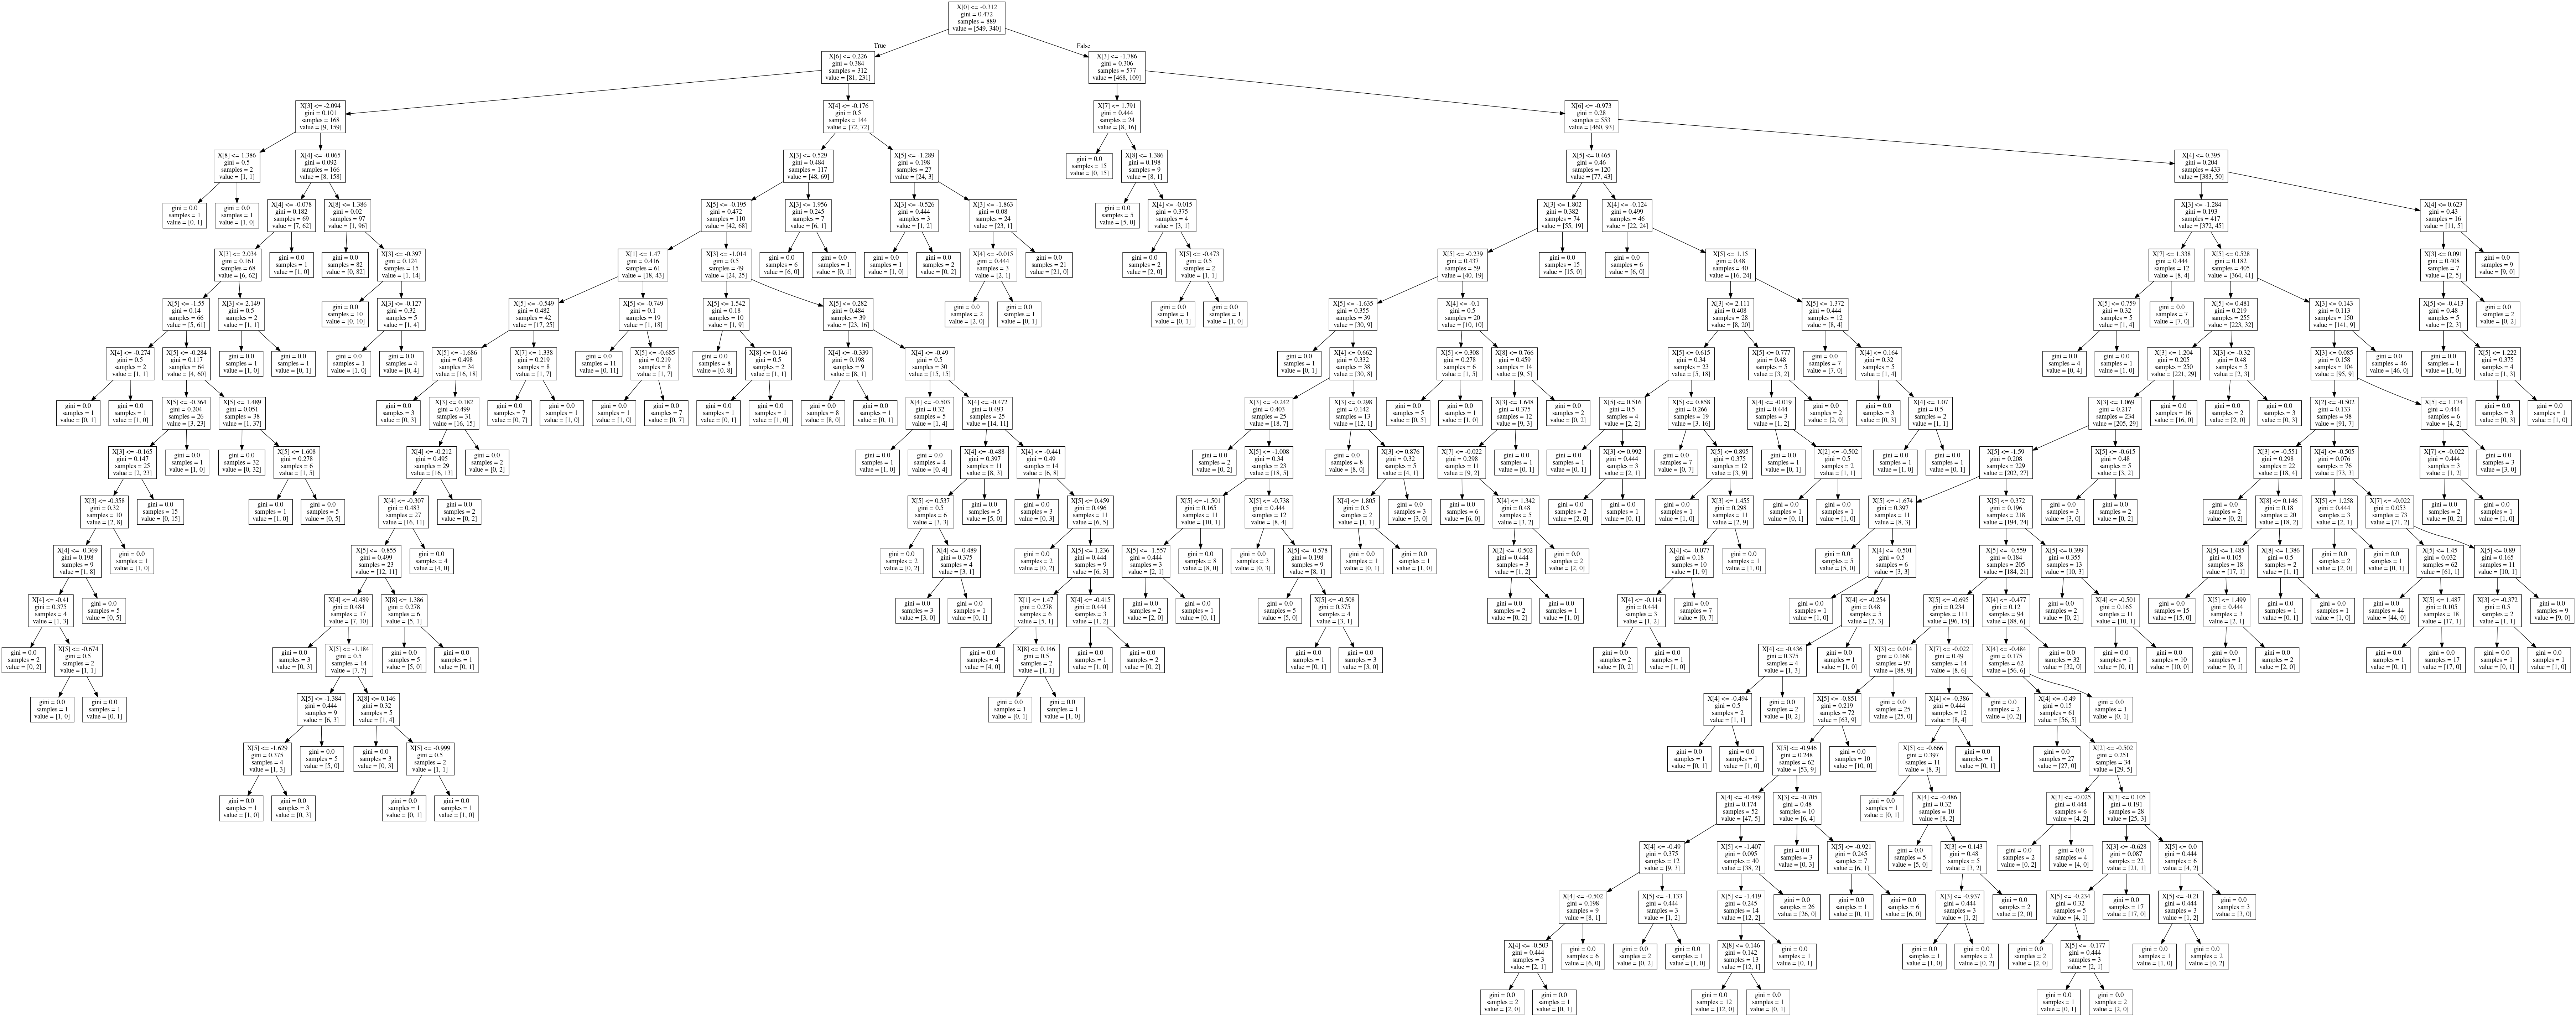

In [14]:
out = StringIO() # create output-object
export_graphviz(dp.mlmodel, out_file=out) # export dotdata to object
graph = pydot.graph_from_dot_data(out.getvalue())[0] # make a graph from dotdata
Image(graph.create_png()) # create png byte data from graph and visualize using Image

## Generate the `temp_grid`

In [22]:
from src.tune import load_hyperparams_mlmodel
from sklearn.model_selection import ParameterGrid
from src.utils import get_training_cv_score, get_best_param_score

In [23]:
hyperparams = load_hyperparams_mlmodel()
hyperparams['DecisionTreeClassifier']

{'ml': [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best')],
 'ml__max_depth': array([ 4.,  7., 12., 21., 35.]),
 'ml__min_samples_split': [2, 5, 10, 20, 40, 0.1, 0.2, 0.3, 0.4, 0.5],
 'ml__min_samples_leaf': [2, 5, 10, 20, 40],
 'ml__max_features': ['sqrt', 'log2', None, 0.1, 0.3, 0.5, 0.7]}

In [24]:
param_grid = {'ml': [DecisionTreeClassifier()],
             'ml__max_depth': max_depth,
             'ml__min_samples_split': [2, 5, 10, 20],
             'ml__min_samples_leaf': [2, 5, 10, 20],
             'ml__max_features': ['sqrt', 0.8, None]}

### Check the length of the `param_grid`. Is it too big for `GridSearchCV`?

In [25]:
len(ParameterGrid(param_grid))

288

### Take out the `pipeline`

In [168]:
from sklearn.model_selection import RepeatedStratifiedKFold
skf = StratifiedKFold(n_splits=5)
rskf = RepeatedStratifiedKFold(n_repeats=3, random_state=1)

In [169]:
pipe = dp.get_pipeline()

In [170]:
pipe.fit(dfX, dfy);
get_training_cv_score(pipe, dfX, dfy, cv=rskf)

Training score: 1.0
crossvalidation score: 0.7527190174293306


## `RandomizedSearchCV`

In [171]:
%%time
grid_search = GridSearchCV(pipe, param_grid, cv=rskf)
grid_search.fit(dfX, dfy)
get_best_param_score(grid_search)

Best param: {'ml': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4.0, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'ml__max_depth': 4.0, 'ml__max_features': 0.8, 'ml__min_samples_leaf': 2, 'ml__min_samples_split': 2}
Best score: 0.8129328562760239
CPU times: user 1min 54s, sys: 331 ms, total: 1min 55s
Wall time: 1min 57s


## See how these best params perform in the other pipeline

In [172]:
from src.pipeline import dp2 

In [173]:
dp2.mlmodel = DecisionTreeClassifier(random_state=1123)
pipe2 = dp2.get_pipeline()

### Training score and crossvalidate accuracy with best params of dp1

In [174]:
pipe2.fit(dfX, dfy)
get_training_cv_score(pipe2, dfX, dfy, cv=rskf)

Training score: 1.0
crossvalidation score: 0.7571966605988325


In [175]:
pipe2.set_params(**grid_search.best_params_);

### Training score and crossvalidate accuracy with best params of dp1

In [176]:
pipe2.fit(dfX, dfy)
get_training_cv_score(pipe2, dfX, dfy, cv=rskf)

Training score: 0.8507295173961841
crossvalidation score: 0.8032096750570168


### Performing new `GridSearchCV` for dp2

dp2 has more redundant features aka more overfitting, hence we can try
- lesser max_depth
- lesser max_features
- higher min_samples_leaf
- higher min_samples_split

In [108]:
%%time
gs = GridSearchCV(pipe2, param_grid, cv=skf).fit(dfX, dfy)

get_best_param_score(gs)

Best param: {'ml': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12.0, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'ml__max_depth': 12.0, 'ml__max_features': 0.8, 'ml__min_samples_leaf': 10, 'ml__min_samples_split': 2}
Best score: 0.8282656455966354
CPU times: user 1min 23s, sys: 181 ms, total: 1min 23s
Wall time: 1min 24s


In [177]:
pipe2 = gs.best_estimator_

In [178]:
res = pd.DataFrame(gs.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.037843,0.016108,0.023621,0.005155,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",4,sqrt,2,2,"{'ml': DecisionTreeClassifier(ccp_alpha=0.0, c...",0.687151,0.764045,0.814607,0.808989,0.797753,0.774509,0.047070,232
1,0.029289,0.002098,0.019565,0.001394,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",4,sqrt,2,5,"{'ml': DecisionTreeClassifier(ccp_alpha=0.0, c...",0.793296,0.792135,0.814607,0.780899,0.803371,0.796861,0.011376,145
2,0.031203,0.002300,0.018993,0.001599,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",4,sqrt,2,10,"{'ml': DecisionTreeClassifier(ccp_alpha=0.0, c...",0.664804,0.820225,0.741573,0.780899,0.865169,0.774534,0.068512,231
3,0.031522,0.001962,0.021302,0.003231,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",4,sqrt,2,20,"{'ml': DecisionTreeClassifier(ccp_alpha=0.0, c...",0.620112,0.786517,0.758427,0.724719,0.820225,0.742000,0.068595,288
4,0.030957,0.002480,0.019629,0.001709,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",4,sqrt,5,2,"{'ml': DecisionTreeClassifier(ccp_alpha=0.0, c...",0.782123,0.769663,0.719101,0.758427,0.735955,0.753054,0.022781,279


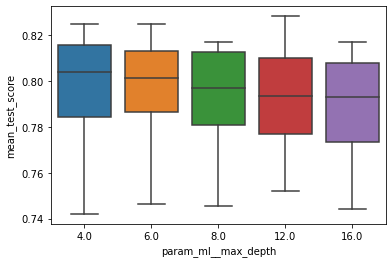

In [179]:
sns.boxplot(x='param_ml__max_depth', y='mean_test_score', data=res)

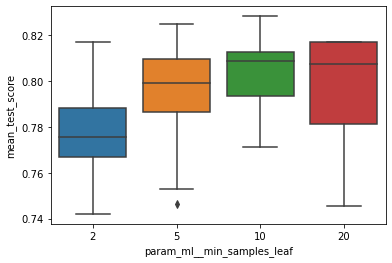

In [180]:
sns.boxplot(x='param_ml__min_samples_leaf', y='mean_test_score', data=res)

In [181]:
def plot_joint_heatmap(gs, x, y, values='mean_test_score', **kwargs):
    pvt = res.pivot_table(values=values, 
                          index=f'param_{x}', 
                          columns=f'param_{y}')
    
    return sns.heatmap(pvt)
    
def plot_joint_heatmap_model(gs, x, y, model_step='ml', values='mean_test_score', **kwargs):
    return plot_joint_heatmap(gs, x=f'{model_step}__{x}',
                              y=f'{model_step}__{y}', values=values, **kwargs)
    

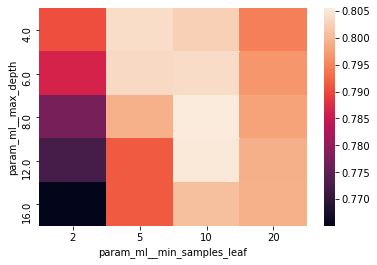

In [182]:
plot_joint_heatmap_model(gs, 'max_depth', 'min_samples_leaf')

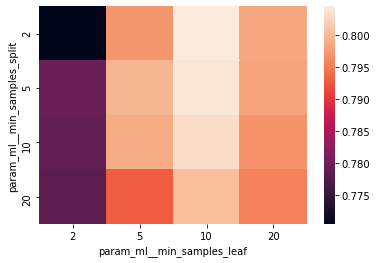

In [183]:
plot_joint_heatmap_model(gs, 'min_samples_split', 'min_samples_leaf')

In [184]:
from copy import deepcopy

class SetParams:
    
    def __init__(self, pipe, **params):
        self.pipe = deepcopy(pipe)
        self.params = params
        
    def __enter__(self):
        self.pipe.set_params(**self.params)
        return self
    
    def __exit__(self, exc_type, exc_val, exc_traceback):
        pass

In [185]:
with SetParams(pipe2, ml__max_depth=4) as setp:
    pipe = setp.pipe
    get_training_cv_score(pipe, dfX, dfy, cv=skf)
    

Training score: 0.8597081930415263
crossvalidation score: 0.8170296905404557


In [189]:
pipe2.named_steps['ml']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12.0, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

<module 'matplotlib.pyplot' from '/home/abhi/miniconda3/envs/titansurv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

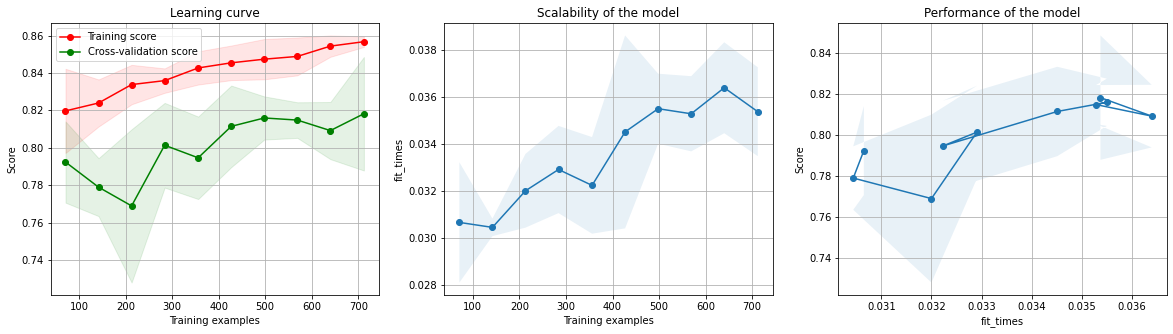

In [188]:
plot_learning_curve(pipe2, 'Learning curve', dfX, dfy, cv=skf, train_sizes=np.linspace(0.1, 1.0, 10))

## Keep a record of a file to store best params of every model you tune

In [60]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt